### Determinação de parâmetros de exoplanetas por ajuste do trânsito pelo algoritmo MCMC

_Por meio da análise da curva de luz de estrelas com trânsitos de exoplanetas e realizando um ajuste dos dados pelo modelo ECLIPSE utilizando o algoritmo MCMC (Markov Chain Monte Carlo) presente neste código, é possível descobrir com maior precisão os parâmetros reais do exoplaneta e sua órbita. O programa foi otimizado para que seu tempo de execução fosse reduzido drasticamente._

In [1]:
#imports
from model import Modelo,Tratamento,Ajuste
from verify import converte
from estrela_nv1 import estrela
from eclipse_nv1 import Eclipse
import numpy
import matplotlib.pyplot as plt
import emcee
from scipy import interpolate
import corner
from lmfit import Model

### Entrada Estrela e Eclipse

_A Estrela e o Eclipse serão criados através de classes auxiliares presentes nos arquivos ```eclipse.py``` e ```estrela.py```. A classe Estrela constrói a matriz que representa a estrela, enquanto a classe Eclipse calcula a curva de luz daquela estrela dado parâmetros planetários imputados. Cada planeta também pode conter uma lua em sua órbita, dessa forma, cada eclipse pode possuir uma ou mais luas, através da classe Moon. 
Os parâmetros de criação da estrela e eclipse, juntamente com a(s) lua(s) estão presentes no bloco abaixo._

In [2]:
# -------------- Parâmetros de entrada --------------
# --------------------- Estrela ---------------------
star_name = 'Kepler-17'
cadence = 'short'
raio = 373. #default (pixel)
intensidadeMaxima = 240 #default
tamanhoMatriz = 856 #default 
u1 = 0.405
u2 = 0.262



# --------------------- Planeta ---------------------
raioPlanJup = 1.312
semiEixoUA = 0.02591
rsun = 1.05 # raio da estrela em Rsun
anguloInclinacao = 87.2 #em graus
periodo = 1.4857108  # day
lua = False 
ecc = 0
anom = 0


#etapa de conversão
raioStar, raioPlanetaRstar , semiEixoRaioStar = converte(rsun,raioPlanJup,semiEixoUA)

### Construção da Estrela e do Eclipse
_Após a construção da matriz estrela e do eclipse calculado, temos a resultante da curva de luz representada graficamente abaixo._

0.09200024604797363


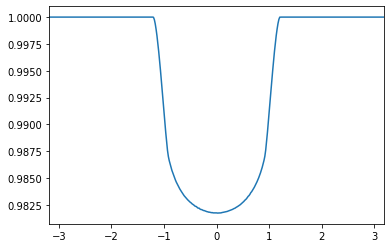

In [3]:
estrela_ = estrela(raio,raioStar,intensidadeMaxima,u1,u2,tamanhoMatriz)
Nx = estrela_.getNx()
Ny = estrela_.getNy()
raioEstrelaPixel = estrela_.getRaioStar()
estrelaManchada = estrela_.getEstrela()
eclipse = Eclipse(Nx,Ny,raioEstrelaPixel,estrelaManchada)
estrela_.setStarName(star_name)
estrela_.setCadence(cadence)
eclipse.setTempoHoras(1.)



#semiEixoRaioStar,semiEixoUA, raioPlanetaRstar, raioPlanJup ,periodo,anguloInclinacao,lua,ecc,anom
eclipse.criarEclipse(semiEixoRaioStar,semiEixoUA,raioPlanetaRstar,raioPlanJup,periodo,anguloInclinacao,lua,ecc,anom,False)
lc0 = numpy.array(eclipse.getCurvaLuz()) 
ts0 = numpy.array(eclipse.getTempoHoras())

### Criar um modelo através do Eclipse 
_Um modelo será criado através da base de curva de luz construída para que o algorimo seja aplicado_

0.0950002670288086


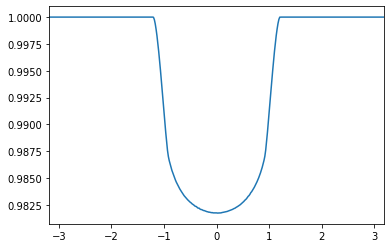

d:\Users\Pinho\Documents\GitHub\pipelineMCMC\model.py:102: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  lc = search_lightcurvefile(self.star_name, cadence = self.cadence).download_all().PDCSAP_FLUX
d:\Users\Pinho\Documents\GitHub\pipelineMCMC\model.py:102: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = search_lightcurvefile(self.star_name, cadence = self.cadence).download_all().PDCSAP_FLUX
d:\Users\Pinho\AppData\Local\Programs\Python\Python38-64\lib\site-packages\lightkurve\collections.py:164: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  return LightCurveCollection([lc.PDCSAP_FLUX for lc in self])
d:\Users\Pinho\AppData\Local\Programs\Python\Python38-64\lib\site-packages\lightkurve\collections.py:164: LightkurveDeprecationWarning: The PDC

In [4]:
modelo = Modelo(estrela_,eclipse)

ls_model, ts_model = modelo.eclipse_model()

time, flux, flux_err = modelo.rd_data(0, 0)

time2 = time

modelo.setTime(time2)
modelo.setFlux(flux)
modelo.setFluxErr(flux_err)

x0, nt = modelo.det_x0(0)

### Tratamendo do modelo 
_Nesta etapa o trânsito será cortado para que seja analisada apenas a etapa onde há variância na curva de luz. A classe ```Modelo``` coleta os dados do telescópio (Kepler ou Tess) obtidos através do ```método de trânsito``` e como esses dados apresentam muitos resíduos, a etapa de tratamento faz-se necessária._

0.08899855613708496


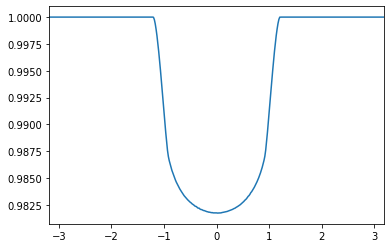

In [5]:
tratamento = Tratamento(modelo)

dur, tim, lcurve, f_err = tratamento.cut_transit_single()

t_p = tim[0]
s_lc = lcurve[0]

bb = numpy.where((t_p >= min(ts0)) & (t_p <= max(ts0)))
bb = numpy.where((ts0 >= -5.) & (ts0 <= 5.))
dd = numpy.where((t_p >= -5.) & (t_p <= 5.))

### Curvas de luz resultantes 
_Abaixo, temos representadas a curva de luz inicial com a curva de luz obtida através dos dados inputados pelo telescópio (```LightKurve```) após o tratamento. É utilizada a curva de luz inicial para a comparação da curva de luz obtida através do telescópio._

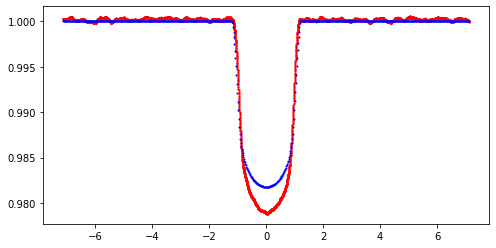

In [6]:
time_phased, smoothed_LC = tratamento.transit_smooth(10, 1)

plt.rcParams['figure.figsize']= 8, 4
graf1,ax = plt.subplots()

ax.plot(time_phased, smoothed_LC, "r.", ms = 2)
ax.plot(ts_model, ls_model, "b.", ms = 2)

# MCMC
_Ajustes realizados para a aplicação do algoritmo MCMC. As variáveis ```nwalkers```, ```niter``` e ```burnin``` podem ser alteradas conforme o pesquisador achar necessário para a aplicação do algoritmo_

In [7]:
nwalkers = 50
niter = 100
burnin = 30

ajuste = Ajuste(tratamento, time_phased, smoothed_LC, nwalkers, niter, burnin)

time = time_phased
flux = smoothed_LC

### Chamada do algoritmo MCMC

In [8]:
sampler, pos, prob, state = ajuste.main()

Running burn-in...


100%|██████████| 30/30 [17:47<00:00, 35.57s/it]


Running production...


100%|██████████| 100/100 [59:07<00:00, 35.47s/it]


### Valores obtidos pós aplicação do algoritmo

In [9]:
samples = sampler.flatchain
samples[numpy.argmax(sampler.flatlnprobability)]

array([6.52932644e-01, 5.08006638e-02, 1.80298013e-02, 8.87514574e+01,
       1.29428985e+00])

### Conclusão 
_Abaixo teremos a curva de luz obtida pelo satélite comparada com a curva de luz tratada através do algoritmo MCMC_

[6.52932644e-01 5.08006638e-02 1.80298013e-02 8.87514574e+01
 1.29428985e+00]


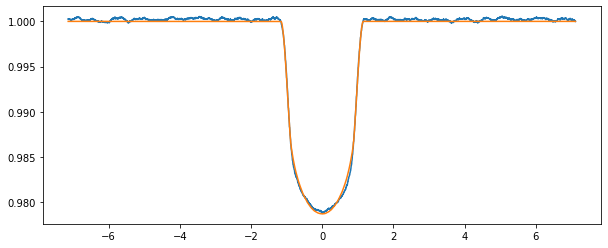

Theta max:  [6.52932644e-01 5.08006638e-02 1.80298013e-02 8.87514574e+01
 1.29428985e+00]


In [10]:
theta_max  = samples[numpy.argmax(sampler.flatlnprobability)]
print(theta_max)
best_fit_model = ajuste.eclipse_mcmc(time, theta_max)

plt.rcParams['figure.figsize']= 10, 4
graf1,ax = plt.subplots()
plt.plot(time, flux, label = 'flux')
plt.plot(time, best_fit_model, label='Highest Likelihood Model')
plt.show()
print('Theta max: ',theta_max)

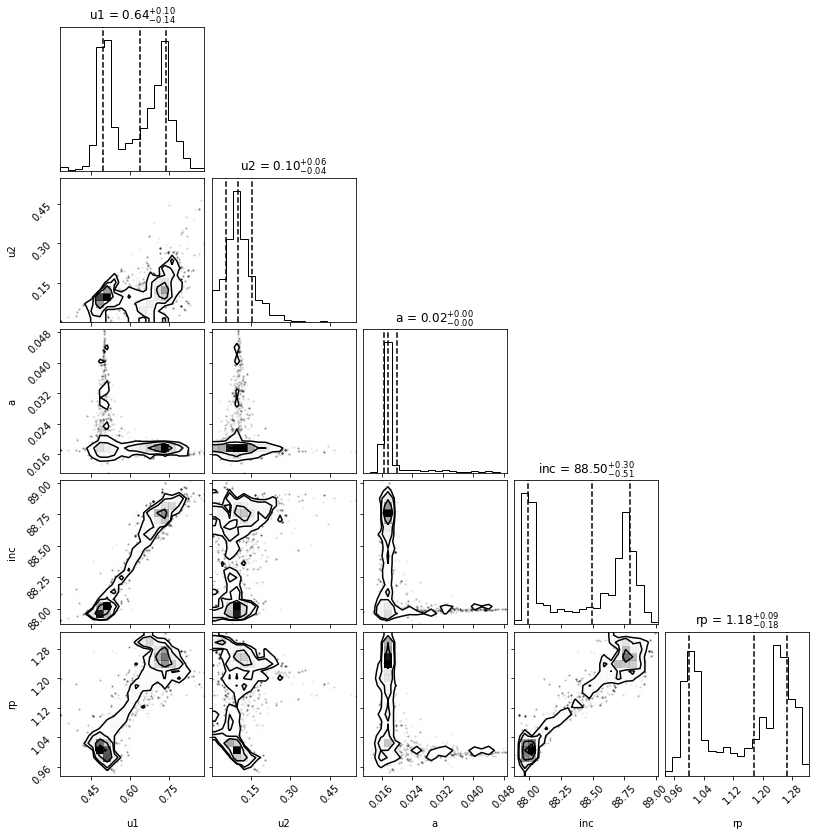

In [11]:
labels = ['u1','u2','a','inc','rp']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])